In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import yfinance as yfinance
import datetime 
import scipy.optimize as optimize
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
from nelson_siegel_svensson import NelsonSiegelCurve
import statsmodels.api as sm
from scipy.stats import kurtosis
%matplotlib inline
import seaborn as sns
from scipy.stats.mstats import gmean
import warnings

In [3]:
df = pd.read_parquet('Trading_app-master/algostrata_isin.parquet')
df.head()

DK0016195431  DK0010289602  DK0060232312  \
2012-01-11 00:00:00+00:00      0.015134      0.006069      0.000887   
2012-01-18 00:00:00+00:00      0.006833      0.008828      0.000000   
2012-01-25 00:00:00+00:00      0.002644      0.011814     -0.000197   
2012-02-01 00:00:00+00:00      0.009142      0.014703      0.000984   
2012-02-08 00:00:00+00:00      0.016551      0.013140     -0.001180   

                           DK0010244854  DK0010270693  DK0016111511  \
2012-01-11 00:00:00+00:00      0.005416      0.021335      0.016686   
2012-01-18 00:00:00+00:00      0.012080      0.001885      0.005471   
2012-01-25 00:00:00+00:00      0.005323      0.006741      0.006696   
2012-02-01 00:00:00+00:00      0.013798      0.000156     -0.007068   
2012-02-08 00:00:00+00:00      0.022472      0.016815      0.014096   

                           DK0010237569  DK0060821064  DK0016112832  \
2012-01-11 00:00:00+00:00      0.030303      0.024658     -0.000281   
2012-01-18 00:00:00+00:00      0.022186      0.008594      0.001265   
2012-01-25 00:00:00+00:00      0.004281     -0.009657      0.007438   
2012-02-01 00:00:00+00:00      0.021315      0.024092      0.011283   
2012-02-08 00:00:00+00:00      0.035624      0.024832      0.003030   

                           DK0060019552  ...  DE000A0H08N1  IE00B52MJY50  \
2012-01-11 00:00:00+00:00     -0.000458  ...     -0.000654      0.015346   
2012-01-18 00:00:00+00:00      0.000763  ...      0.012985      0.009096   
2012-01-25 00:00:00+00:00      0.007471  ...      0.000486      0.015004   
2012-02-01 00:00:00+00:00      0.010670  ...      0.028292     -0.003084   
2012-02-08 00:00:00+00:00      0.003220  ...      0.003624      0.018755   

                           IE00B6R52259  IE00B5BMR087  IE00B3ZW0K18  \
2012-01-11 00:00:00+00:00      0.020060      0.029827      0.012299   
2012-01-18 00:00:00+00:00      0.006481      0.001870      0.010046   
2012-01-25 00:00:00+00:00      0.004967      0.001372      0.009221   
2012-02-01 00:00:00+00:00     -0.003798     -0.018339      0.008531   
2012-02-08 00:00:00+00:00      0.015051      0.015560      0.013891   

                           IE00B2QWDY88  LU0322253229  LU0290357929  \
2012-01-11 00:00:00+00:00      0.004881      0.006464      0.004637   
2012-01-18 00:00:00+00:00     -0.008594      0.001089      0.006495   
2012-01-25 00:00:00+00:00      0.000421     -0.008601     -0.008965   
2012-02-01 00:00:00+00:00      0.009153      0.016737      0.015042   
2012-02-08 00:00:00+00:00      0.002510      0.002792     -0.002704   

                           LU0478205379  DE0002635265  
2012-01-11 00:00:00+00:00      0.003364      0.003310  
2012-01-18 00:00:00+00:00      0.003850      0.000941  
2012-01-25 00:00:00+00:00      0.004883      0.001401  
2012-02-01 00:00:00+00:00      0.008338      0.002710  
2012-02-08 00:00:00+00:00      0.001531     -0.000444  

[5 rows x 717 columns]

# Strategy 1

**Minimum Spanning Tree.**

- Start with all the assets available in the Investment Funnel for the entire period. Divide this period into half, where the first half is used for training and the second half for testing.
- Q1: Now calculate the Sharpe Ratio for all the assets for the first half (the training set).

## Q1: Now calculate the Sharpe Ratio for all the assets for the first half (the training set).

In [4]:
split=int(len(df)*0.5)
training=df[:split]
test=df[split:]

In [5]:
training.head()

DK0016195431  DK0010289602  DK0060232312  \
2012-01-11 00:00:00+00:00      0.015134      0.006069      0.000887   
2012-01-18 00:00:00+00:00      0.006833      0.008828      0.000000   
2012-01-25 00:00:00+00:00      0.002644      0.011814     -0.000197   
2012-02-01 00:00:00+00:00      0.009142      0.014703      0.000984   
2012-02-08 00:00:00+00:00      0.016551      0.013140     -0.001180   

                           DK0010244854  DK0010270693  DK0016111511  \
2012-01-11 00:00:00+00:00      0.005416      0.021335      0.016686   
2012-01-18 00:00:00+00:00      0.012080      0.001885      0.005471   
2012-01-25 00:00:00+00:00      0.005323      0.006741      0.006696   
2012-02-01 00:00:00+00:00      0.013798      0.000156     -0.007068   
2012-02-08 00:00:00+00:00      0.022472      0.016815      0.014096   

                           DK0010237569  DK0060821064  DK0016112832  \
2012-01-11 00:00:00+00:00      0.030303      0.024658     -0.000281   
2012-01-18 00:00:00+00:00      0.022186      0.008594      0.001265   
2012-01-25 00:00:00+00:00      0.004281     -0.009657      0.007438   
2012-02-01 00:00:00+00:00      0.021315      0.024092      0.011283   
2012-02-08 00:00:00+00:00      0.035624      0.024832      0.003030   

                           DK0060019552  ...  DE000A0H08N1  IE00B52MJY50  \
2012-01-11 00:00:00+00:00     -0.000458  ...     -0.000654      0.015346   
2012-01-18 00:00:00+00:00      0.000763  ...      0.012985      0.009096   
2012-01-25 00:00:00+00:00      0.007471  ...      0.000486      0.015004   
2012-02-01 00:00:00+00:00      0.010670  ...      0.028292     -0.003084   
2012-02-08 00:00:00+00:00      0.003220  ...      0.003624      0.018755   

                           IE00B6R52259  IE00B5BMR087  IE00B3ZW0K18  \
2012-01-11 00:00:00+00:00      0.020060      0.029827      0.012299   
2012-01-18 00:00:00+00:00      0.006481      0.001870      0.010046   
2012-01-25 00:00:00+00:00      0.004967      0.001372      0.009221   
2012-02-01 00:00:00+00:00     -0.003798     -0.018339      0.008531   
2012-02-08 00:00:00+00:00      0.015051      0.015560      0.013891   

                           IE00B2QWDY88  LU0322253229  LU0290357929  \
2012-01-11 00:00:00+00:00      0.004881      0.006464      0.004637   
2012-01-18 00:00:00+00:00     -0.008594      0.001089      0.006495   
2012-01-25 00:00:00+00:00      0.000421     -0.008601     -0.008965   
2012-02-01 00:00:00+00:00      0.009153      0.016737      0.015042   
2012-02-08 00:00:00+00:00      0.002510      0.002792     -0.002704   

                           LU0478205379  DE0002635265  
2012-01-11 00:00:00+00:00      0.003364      0.003310  
2012-01-18 00:00:00+00:00      0.003850      0.000941  
2012-01-25 00:00:00+00:00      0.004883      0.001401  
2012-02-01 00:00:00+00:00      0.008338      0.002710  
2012-02-08 00:00:00+00:00      0.001531     -0.000444  

[5 rows x 717 columns]

In [6]:
stats_train = pd.DataFrame(index = training.columns, columns  =["Ave Hist Returns (Ann)", "Stdev (Ann)", 'Min', 'Max', 
                                                      'Range', 'Kurtosis',
                                                      'Skewness', "AutoCorr", "Sharpe"])

In [7]:
def annualize_logreturns(returns, data_freq='weekly'):
    if data_freq=='weekly':
        return returns*52
    elif data_freq=='daily':
        return returns*252

def annualize_stddev(stddev, data_freq='weekly'):
    if data_freq=='weekly':
        return stddev*np.sqrt(52)
    elif data_freq=='daily':
        return stddev*np.sqrt(252)

# Function to calculate average returns using geometric mean
def calc_mean(returns):
    return (np.prod(1 + returns))**(1/len(returns)) - 1

weeklymean = calc_mean(training)
weeklycov = training.cov()

annual_mean = (1+weeklymean)**52-1

annual_cov = weeklycov*52

print("The annual mean is:\n", annual_mean)
print("\nThe annual cov matrix:\n", annual_cov)

The annual mean is:
 DK0016195431    0.072858
DK0010289602    0.088213
DK0060232312    0.008095
DK0010244854    0.086263
DK0010270693    0.101740
                  ...   
IE00B2QWDY88    0.140640
LU0322253229    0.105699
LU0290357929    0.041007
LU0478205379    0.040348
DE0002635265    0.025412
Length: 717, dtype: float64

The annual cov matrix:
               DK0016195431  DK0010289602  DK0060232312  DK0010244854  \
DK0016195431      0.010763      0.013394      0.000165      0.016432   
DK0010289602      0.013394      0.018047      0.000167      0.021168   
DK0060232312      0.000165      0.000167      0.000088      0.000177   
DK0010244854      0.016432      0.021168      0.000177      0.028153   
DK0010270693      0.015680      0.019886      0.000218      0.023902   
...                    ...           ...           ...           ...   
IE00B2QWDY88      0.009329      0.011819      0.000347      0.013416   
LU0322253229      0.011242      0.014281      0.000339      0.017383   
LU0

In [8]:
stats_train["Ave Hist Returns (Ann)"] = annual_mean
stats_train["Stdev (Ann)"] = np.sqrt(np.diag(annual_cov))
stats_train["Min"] = training.min()
stats_train["Max"] = training.max()
stats_train["Range"] = abs(training.min()-training.max())
stats_train["Kurtosis"] = training.kurtosis()
stats_train["Skewness"] = training.skew()
stats_train["Sharpe"] = stats_train["Ave Hist Returns (Ann)"]/stats_train["Stdev (Ann)"]

In [9]:
a = training.columns

# autocorrelations
for i in range(717):
    x,y = sm.tsa.acf(training[a[i]],nlags=1)
    stats_train.iloc[i,7] = y 

C:\Users\bjark\Anaconda3\envs\BjarkiLord\lib\site-packages\statsmodels\tsa\stattools.py:666: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [10]:
stats_train

Ave Hist Returns (Ann)  Stdev (Ann)       Min       Max  \
DK0016195431                0.072858     0.103745 -0.056368  0.038553   
DK0010289602                0.088213     0.134341 -0.074171  0.051553   
DK0060232312                0.008095     0.009376 -0.008031  0.003097   
DK0010244854                0.086263     0.167789 -0.075489  0.066038   
DK0010270693                0.101740     0.157152 -0.094646  0.072137   
...                              ...          ...       ...       ...   
IE00B2QWDY88                0.140640     0.167221 -0.091861  0.077577   
LU0322253229                0.105699     0.137147 -0.095202  0.067952   
LU0290357929                0.041007     0.052936 -0.022392  0.028369   
LU0478205379                0.040348     0.020619 -0.011732  0.010136   
DE0002635265                0.025412     0.014199 -0.006585  0.005366   

                 Range  Kurtosis  Skewness   AutoCorr    Sharpe  
DK0016195431  0.094921  1.124994 -0.336192  -0.108577  0.702279  
DK0010289602  0.125725  1.465322 -0.452017  -0.140443  0.656639  
DK0060232312  0.011129  9.041547 -1.791588    0.15879  0.863369  
DK0010244854  0.141526  0.778684 -0.246073  -0.140265  0.514117  
DK0010270693  0.166783  2.149429 -0.446288  -0.126609  0.647400  
...                ...       ...       ...        ...       ...  
IE00B2QWDY88  0.169437  1.805662 -0.571716 -0.0132726  0.841046  
LU0322253229  0.163154  3.239528 -0.555363 -0.0599387  0.770697  
LU0290357929  0.050762  1.099230 -0.004751 -0.0524988  0.774647  
LU0478205379  0.021868  2.570531 -0.650428  0.0821568  1.956836  
DE0002635265  0.011952  0.689658 -0.260003 -0.0235242  1.789625  

[717 rows x 9 columns]

## Q2: Pick up the top 4-5 assets with the highest Sharpe Ratios for the training set.


**Top 5 assets with the highest Sharp Ratios**

In [11]:
#Question 2

top_5_train = stats_train.nlargest(5, 'Sharpe')
top_5_train

Ave Hist Returns (Ann)  Stdev (Ann)       Min       Max  \
DK0016306798                0.104291     0.038374 -0.020745  0.017109   
DK0060005098                0.038332     0.014187 -0.008366  0.005251   
DK0016044654                0.070977     0.026300 -0.016883  0.014713   
DK0060356392                0.060824     0.023772 -0.016749  0.010753   
DK0016202740                0.062532     0.025385 -0.013480  0.011231   

                 Range  Kurtosis  Skewness   AutoCorr    Sharpe  
DK0016306798  0.037854  2.788184 -0.473494   0.326699  2.717760  
DK0060005098  0.013617  2.229424 -0.740153  0.0722997  2.701868  
DK0016044654  0.031595  4.387780 -0.665260   0.109203  2.698767  
DK0060356392  0.027502  4.718392 -1.020688   0.130835  2.558705  
DK0016202740  0.024712  2.072244 -0.660235   0.139084  2.463309

**Strategy 1:**
- Q2: Pick up the top 4-5 assets with the highest Sharpe Ratios for the training set.
- Q3: Calculate the covariance matrix for these assets.
- Q4: Make an equal weight portfolio of these assets and test their performance on your testing data now.

In [12]:
training_best = training[['DK0016306798','DK0060005098','DK0016044654', 'DK0060356392', 'DK0016202740']]
testing_best = test[['DK0016306798','DK0060005098','DK0016044654', 'DK0060356392', 'DK0016202740']]
training_best.head()

DK0016306798  DK0060005098  DK0016044654  \
2012-01-11 00:00:00+00:00      0.010978      0.000957     -0.006240   
2012-01-18 00:00:00+00:00      0.012636     -0.000191      0.014027   
2012-01-25 00:00:00+00:00      0.014915     -0.003157      0.006003   
2012-02-01 00:00:00+00:00      0.012679      0.003071      0.011109   
2012-02-08 00:00:00+00:00      0.015840     -0.002583      0.002936   

                           DK0060356392  DK0016202740  
2012-01-11 00:00:00+00:00     -0.000196      0.003564  
2012-01-18 00:00:00+00:00      0.006576      0.006477  
2012-01-25 00:00:00+00:00      0.005656      0.007265  
2012-02-01 00:00:00+00:00      0.010084      0.011231  
2012-02-08 00:00:00+00:00      0.001728      0.003872

## Q3: Calculate the covariance matrix for these assets.


In [13]:
## Question 3
covmat = training_best.cov()

print('Covariance matrix of daily returns')
print(covmat)

Covariance matrix of daily returns
              DK0016306798  DK0060005098  DK0016044654  DK0060356392  \
DK0016306798      0.000028      0.000002      0.000011      0.000010   
DK0060005098      0.000002      0.000004      0.000004      0.000004   
DK0016044654      0.000011      0.000004      0.000013      0.000012   
DK0060356392      0.000010      0.000004      0.000012      0.000011   
DK0016202740      0.000011      0.000004      0.000011      0.000010   

              DK0016202740  
DK0016306798      0.000011  
DK0060005098      0.000004  
DK0016044654      0.000011  
DK0060356392      0.000010  
DK0016202740      0.000012  


In [14]:
## Question 4 - Make an equal weight portfolio of these assets and test their performance on your testing data now.

# Function to calculate average returns using geometric mean
def calc_mean(training_best ):
    return (np.prod(1 + training_best ))**(1/len(training_best)) - 1

# Training
weeklymean_best_train = calc_mean(training_best)
weeklycov_best_train = training_best.cov()
annual_mean_best_train = (1+weeklymean_best_train)**52-1
annual_cov_best_train = weeklycov_best_train*52

#Testing
weeklymean_best_test = calc_mean(testing_best)
weeklycov_best_test = testing_best.cov()
annual_mean_best_test = (1+weeklymean_best_test)**52-1
annual_cov_best_test = weeklycov_best_test*52

print("The annual best train mean is:\n", annual_mean_best_train)
print("\nThe annual best train cov matrix:\n", annual_cov_best_train)
print('--------------------------------------------')
print("The annual best test mean is:\n", annual_mean_best_test)
print("\nThe annual best test cov matrix:\n", annual_cov_best_test)


The annual best train mean is:
 DK0016306798    0.104291
DK0060005098    0.038332
DK0016044654    0.070977
DK0060356392    0.060824
DK0016202740    0.062532
dtype: float64

The annual best train cov matrix:
               DK0016306798  DK0060005098  DK0016044654  DK0060356392  \
DK0016306798      0.001473      0.000109      0.000589      0.000507   
DK0060005098      0.000109      0.000201      0.000219      0.000213   
DK0016044654      0.000589      0.000219      0.000692      0.000605   
DK0060356392      0.000507      0.000213      0.000605      0.000565   
DK0016202740      0.000553      0.000205      0.000582      0.000532   

              DK0016202740  
DK0016306798      0.000553  
DK0060005098      0.000205  
DK0016044654      0.000582  
DK0060356392      0.000532  
DK0016202740      0.000644  
--------------------------------------------
The annual best test mean is:
 DK0016306798    0.040150
DK0060005098    0.008613
DK0016044654    0.026132
DK0060356392    0.018743
DK0016202

In [15]:
w_eq = np.empty(5)
for i in range(5):
    w_eq[i] = 1/5
    
eqwp_return_train = np.sum(np.transpose(w_eq)*np.array(annual_mean_best_train))
eqwp_risk_train = np.sqrt(np.dot(np.transpose(w_eq), np.dot(annual_cov_best_train, w_eq)))

eqwp_return_test = np.sum(np.transpose(w_eq)*np.array( annual_mean_best_test))
eqwp_risk_test = np.sqrt(np.dot(np.transpose(w_eq), np.dot(annual_cov_best_test, w_eq)))


print("------Train------")
print("Return: ", eqwp_return_train)
print("Risk: ", eqwp_risk_train)
print("Sharp ratio: ",eqwp_return_train/eqwp_risk_train )
print("------Test------")
print("Return: ", eqwp_return_test)
print("Risk: ", eqwp_risk_test)
print("Sharp ratio: ",eqwp_return_test/eqwp_risk_test )

------Train------
Return:  0.0673913651436826
Risk:  0.02172972706170218
Sharp ratio:  3.101344299094181
------Test------
Return:  0.022650047656189852
Risk:  0.03854270151205878
Sharp ratio:  0.5876611334341308


## Q4: Make an equal weight portfolio of these assets and test their performance on your testing data now.

<function matplotlib.pyplot.show(close=None, block=None)>

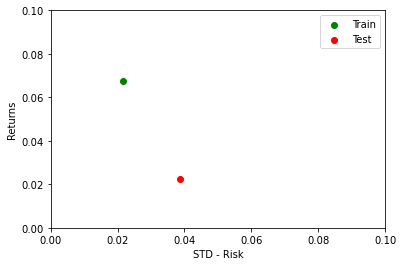

In [16]:
plt.scatter(eqwp_risk_train, eqwp_return_train, color = 'green', label = "Train")
plt.scatter(eqwp_risk_test, eqwp_return_test, color= 'red', label = "Test")
plt.legend()
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
plt.xlabel('STD - Risk')
plt.ylabel('Returns')

plt.show

In [17]:
weights = [1/5,1/5,1/5,1/5,1/5]

In [18]:
testing_best["portfolio"] = testing_best.dot(weights)

C:\Users\bjark\Anaconda3\envs\BjarkiLord\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
daily_cum_ret = (1 + testing_best).cumprod()
daily_cum_ret.head()

DK0016306798  DK0060005098  DK0016044654  \
2016-11-02 00:00:00+00:00      0.996825      0.998439      0.997516   
2016-11-09 00:00:00+00:00      0.993651      0.999317      0.995219   
2016-11-16 00:00:00+00:00      0.994533      0.994438      0.986106   
2016-11-23 00:00:00+00:00      0.995326      0.995121      0.983364   
2016-11-30 00:00:00+00:00      0.997178      0.996391      0.985364   

                           DK0060356392  DK0016202740  portfolio  
2016-11-02 00:00:00+00:00      0.997513      0.997513   0.997561  
2016-11-09 00:00:00+00:00      0.995455      0.994926   0.995713  
2016-11-16 00:00:00+00:00      0.986364      0.985773   0.989443  
2016-11-23 00:00:00+00:00      0.983877      0.985375   0.988608  
2016-11-30 00:00:00+00:00      0.984561      0.985275   0.989748

In [20]:
# Using plotly.express
import plotly.express as px

fig = px.line(daily_cum_ret, y="portfolio", title = "Cumulative returns for the testing portfolio over time")
fig.show()

# Strategy 2

**Strategy 2:**
    
- Q5: Pick up the top 200 assets with the highest Sharpe Ratios for the training set.
- Q6: Run the Minimum Spanning Tree method on this set a number of times until you haveonly about 4-5 assets left.
- Q7: Calculate the covariance matrix for these assets now and compare with the covariancematrix from strategy 1.
- Q8: Make an equal weight portfolio of these assets and test their performance on yourtesting data now.Compare the performance of the two strategies:
- Q9: Calculate average return, std for the two strategies and compare.
- Q10: Calculate and compare the Sharpe ratio for the two strategies.
- Q11: Calculate and compare maximum drawdown for the two strategies

In [21]:
raw_data = pd.read_parquet('Trading_app-master/algostrata_isin.parquet')

split_raw=int(len(raw_data)*0.5)
train_data= raw_data[:split]
test_data= raw_data[split:]



In [22]:
weeklymean_200 = calc_mean(train_data)
weeklycov_200 = train_data.cov()

annual_mean_200 = (1+weeklymean_200)**52-1
annual_cov_200 = weeklycov_200*52

stats_200 = pd.DataFrame(index = train_data.columns, columns  =["Ave Hist Returns (Ann)", "Stdev (Ann)", "Sharpe"])


stats_200["Ave Hist Returns (Ann)"] = annual_mean_200
stats_200["Stdev (Ann)"] = np.sqrt(np.diag(annual_cov_200))
stats_200["Sharpe"] = stats_200["Ave Hist Returns (Ann)"]/stats_200["Stdev (Ann)"]

stats_200


Ave Hist Returns (Ann)  Stdev (Ann)    Sharpe
DK0016195431                0.072858     0.103745  0.702279
DK0010289602                0.088213     0.134341  0.656639
DK0060232312                0.008095     0.009376  0.863369
DK0010244854                0.086263     0.167789  0.514117
DK0010270693                0.101740     0.157152  0.647400
...                              ...          ...       ...
IE00B2QWDY88                0.140640     0.167221  0.841046
LU0322253229                0.105699     0.137147  0.770697
LU0290357929                0.041007     0.052936  0.774647
LU0478205379                0.040348     0.020619  1.956836
DE0002635265                0.025412     0.014199  1.789625

[717 rows x 3 columns]

In [23]:
top_200 = stats_200.nlargest(200, 'Sharpe')
topp_200 = top_200.T
b_topp_200 = topp_200.columns
topp_200.head()

DK0016306798  DK0060005098  DK0016044654  \
Ave Hist Returns (Ann)      0.104291      0.038332      0.070977   
Stdev (Ann)                 0.038374      0.014187      0.026300   
Sharpe                      2.717760      2.701868      2.698767   

                        DK0060356392  DK0016202740  DK0016109614  \
Ave Hist Returns (Ann)      0.060824      0.062532      0.016789   
Stdev (Ann)                 0.023772      0.025385      0.007000   
Sharpe                      2.558705      2.463309      2.398294   

                        DK0060822468  DK0060789667  DK0016075294  \
Ave Hist Returns (Ann)      0.016789      0.066928      0.066928   
Stdev (Ann)                 0.007000      0.028679      0.028679   
Sharpe                      2.398294      2.333733      2.333733   

                        DK0060787109  ...  DK0060096030  LU0174119775  \
Ave Hist Returns (Ann)      0.064962  ...      0.114010      0.197309   
Stdev (Ann)                 0.027870  ...      0.100196      0.173748   
Sharpe                      2.330913  ...      1.137859      1.135603   

                        LU0129459060  LU1735613421  DK0060294692  \
Ave Hist Returns (Ann)      0.184250      0.048562      0.060058   
Stdev (Ann)                 0.163129      0.043001      0.053192   
Sharpe                      1.129477      1.129324      1.129082   

                        DK0060788420  DK0010298272  DK0060039824  \
Ave Hist Returns (Ann)      0.060058      0.173861      0.131215   
Stdev (Ann)                 0.053192      0.154952      0.116973   
Sharpe                      1.129082      1.122029      1.121754   

                        DK0060788503  DK0060448918  
Ave Hist Returns (Ann)      0.058068      0.058068  
Stdev (Ann)                 0.051907      0.051907  
Sharpe                      1.118678      1.118678  

[3 rows x 200 columns]

In [24]:
b_topp_200 = topp_200.columns

In [25]:
best_200 = train_data[b_topp_200]
best_200

DK0016306798  DK0060005098  DK0016044654  \
2012-01-11 00:00:00+00:00      0.010978      0.000957     -0.006240   
2012-01-18 00:00:00+00:00      0.012636     -0.000191      0.014027   
2012-01-25 00:00:00+00:00      0.014915     -0.003157      0.006003   
2012-02-01 00:00:00+00:00      0.012679      0.003071      0.011109   
2012-02-08 00:00:00+00:00      0.015840     -0.002583      0.002936   
...                                 ...           ...           ...   
2016-09-28 00:00:00+00:00      0.000178      0.001663      0.005149   
2016-10-05 00:00:00+00:00      0.000623      0.000293     -0.005140   
2016-10-12 00:00:00+00:00      0.000445     -0.001171     -0.003196   
2016-10-19 00:00:00+00:00      0.004443      0.000195      0.002081   
2016-10-26 00:00:00+00:00      0.003273      0.001368     -0.001558   

                           DK0060356392  DK0016202740  DK0016109614  \
2012-01-11 00:00:00+00:00     -0.000196      0.003564      0.000435   
2012-01-18 00:00:00+00:00      0.006576      0.006477     -0.000435   
2012-01-25 00:00:00+00:00      0.005656      0.007265     -0.000978   
2012-02-01 00:00:00+00:00      0.010084      0.011231      0.001414   
2012-02-08 00:00:00+00:00      0.001728      0.003872     -0.001630   
...                                 ...           ...           ...   
2016-09-28 00:00:00+00:00      0.004698      0.005462      0.001213   
2016-10-05 00:00:00+00:00     -0.005186     -0.005037     -0.000661   
2016-10-12 00:00:00+00:00     -0.003589     -0.002283     -0.000881   
2016-10-19 00:00:00+00:00      0.001801      0.001691      0.000110   
2016-10-26 00:00:00+00:00     -0.001798     -0.001689     -0.000441   

                           DK0060822468  DK0060789667  DK0016075294  \
2012-01-11 00:00:00+00:00      0.000435      0.004900      0.004900   
2012-01-18 00:00:00+00:00     -0.000435      0.006225      0.006225   
2012-01-25 00:00:00+00:00     -0.000978      0.009693      0.009693   
2012-02-01 00:00:00+00:00      0.001414      0.010927      0.010927   
2012-02-08 00:00:00+00:00     -0.001630      0.006263      0.006263   
...                                 ...           ...           ...   
2016-09-28 00:00:00+00:00      0.001213      0.005528      0.005528   
2016-10-05 00:00:00+00:00     -0.000661     -0.004174     -0.004174   
2016-10-12 00:00:00+00:00     -0.000881     -0.002760     -0.002760   
2016-10-19 00:00:00+00:00      0.000110      0.001948      0.001948   
2016-10-26 00:00:00+00:00     -0.000441     -0.001023     -0.001023   

                           DK0060787109  ...  DK0060096030  LU0174119775  \
2012-01-11 00:00:00+00:00      0.004932  ...      0.000000      0.029827   
2012-01-18 00:00:00+00:00      0.005724  ...     -0.000595      0.003737   
2012-01-25 00:00:00+00:00      0.009893  ...      0.001686      0.001369   
2012-02-01 00:00:00+00:00      0.010735  ...      0.007922     -0.002485   
2012-02-08 00:00:00+00:00      0.006169  ...      0.007565      0.030303   
...                                 ...  ...           ...           ...   
2016-09-28 00:00:00+00:00      0.005492  ...      0.000863      0.003842   
2016-10-05 00:00:00+00:00     -0.004317  ...     -0.011790      0.001859   
2016-10-12 00:00:00+00:00     -0.002743  ...     -0.010883      0.003753   
2016-10-19 00:00:00+00:00      0.002396  ...      0.009061      0.006720   
2016-10-26 00:00:00+00:00     -0.001151  ...     -0.009505      0.008043   

                           LU0129459060  LU1735613421  DK0060294692  \
2012-01-11 00:00:00+00:00      0.033332      0.005554      0.007544   
2012-01-18 00:00:00+00:00     -0.000965      0.004056      0.002877   
2012-01-25 00:00:00+00:00     -0.000945      0.005241      0.008409   
2012-02-01 00:00:00+00:00     -0.010417      0.006285      0.007477   
2012-02-08 00:00:00+00:00      0.016591      0.005216      0.008311   
...                                 ...           ...           ...   
2016-09-28 00:00:00+00:00      0.001741      0.001741     

**Minimal spanning tree**

In [26]:
import MST
import Clustering

In [27]:
subset, subset_df, corr_avg, PDI = MST.MinimumSpanningTree(best_200)
print("Average correlation of assets after",1,"iterations:",corr_avg)
print("Number of assets after",1,"iterations:",len(subset))

# 5 iterations of MST
for i in range (1,5):
    subset, subset_df, corr_avg, PDI = MST.MinimumSpanningTree(subset_df)
    print("\nAverage correlation of assets after",i+1,"iterations:",corr_avg)
    print("Number of assets after",i+1,"iterations:",len(subset))
print("\nMST subset of assets: \n")
subset

Average correlation of assets after 1 iterations: 0.3510943682919276
Number of assets after 1 iterations: 105

Average correlation of assets after 2 iterations: 0.3238293179818887
Number of assets after 2 iterations: 59

Average correlation of assets after 3 iterations: 0.3033072890876369
Number of assets after 3 iterations: 29

Average correlation of assets after 4 iterations: 0.27923073344063415
Number of assets after 4 iterations: 14

Average correlation of assets after 5 iterations: 0.304558425061089
Number of assets after 5 iterations: 7

MST subset of assets: 



['DK0016272602',
 'DK0060158590',
 'DK0060941201',
 'DK0010106111',
 'DK0060498509',
 'DK0060188902',
 'LU1001671582']

In [28]:
train_span = test_data[subset_df.columns]
test_span = test_data[subset_df.columns]


In [29]:
#Training
weeklymean_train_span = calc_mean(train_span)
weeklycov_train_span = train_span.cov()
annual_mean_train_span = (1+weeklymean_train_span)**52-1
annual_cov_train_span = weeklycov_train_span*52

#Testing
weeklymean_test_span = calc_mean(test_span)
weeklycov_test_span = test_span.cov()
annual_mean_test_span = (1+weeklymean_test_span)**52-1
annual_cov_test_span= weeklycov_test_span*52

w_eq = np.empty(7)

for i in range(7):
    w_eq[i] = 1/7
    
#testing
eqwp_return_train_span = np.sum(np.transpose(w_eq)*np.array(annual_mean_train_span))
eqwp_risk_train_span = np.sqrt(np.dot(np.transpose(w_eq), np.dot(annual_cov_train_span, w_eq)))

#training
eqwp_return_test_span = np.sum(np.transpose(w_eq)*np.array(annual_mean_test_span))
eqwp_risk_test_span = np.sqrt(np.dot(np.transpose(w_eq), np.dot(annual_cov_test_span, w_eq)))

In [30]:
print("------Train------")
print("Return: ", eqwp_return_train_span )
print("Risk: ", eqwp_risk_train_span)
print("Sharp ratio: ",eqwp_return_train_span/eqwp_risk_train_span)
print("------Test------")
print("Return: ", eqwp_return_test_span)
print("Risk: ", eqwp_risk_test_span)
print("Sharp ratio: ",eqwp_return_test_span/eqwp_risk_test_span)

------Train------
Return:  0.07167045502194938
Risk:  0.07608947815853755
Sharp ratio:  0.9419233349533449
------Test------
Return:  0.07167045502194938
Risk:  0.07608947815853755
Sharp ratio:  0.9419233349533449


## Q8: Make an equal weight portfolio of these assets and test their performance on yourtesting data now.Compare the performance of the two strategies:

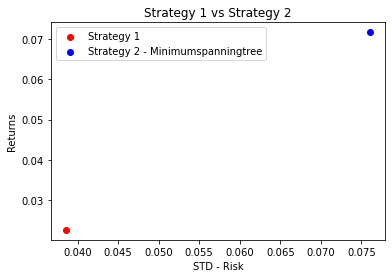

In [31]:
plt.scatter(eqwp_risk_test, eqwp_return_test, color= 'red', label = "Strategy 1")
plt.scatter(eqwp_risk_test_span, eqwp_return_test_span, color= 'blue', label = "Strategy 2 - Minimumspanningtree")
plt.legend()
plt.title("Strategy 1 vs Strategy 2")
#plt.xlim(0, 0.1)
#plt.ylim(0, 0.1)
plt.xlabel('STD - Risk')
plt.ylabel('Returns')
plt.show()

In [32]:
weights = [1/7,1/7,1/7,1/7,1/7,1/7,1/7]

In [33]:
test_span["portfolio"] = test_span.dot(weights)

C:\Users\bjark\Anaconda3\envs\BjarkiLord\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
daily_cum_ret_2 = (1 + test_span).cumprod()
daily_cum_ret_2.head()

DK0016272602  DK0060158590  DK0060941201  \
2016-11-02 00:00:00+00:00      0.966220      0.999002      0.999830   
2016-11-09 00:00:00+00:00      0.964430      0.999002      1.000510   
2016-11-16 00:00:00+00:00      0.976045      0.999002      0.999915   
2016-11-23 00:00:00+00:00      0.971095      0.999002      1.000000   
2016-11-30 00:00:00+00:00      0.977051      0.998890      1.000450   

                           DK0010106111  DK0060498509  DK0060188902  \
2016-11-02 00:00:00+00:00      1.000515      0.995450      0.963392   
2016-11-09 00:00:00+00:00      0.999691      1.001312      0.955298   
2016-11-16 00:00:00+00:00      0.998351      0.988538      0.948979   
2016-11-23 00:00:00+00:00      0.998145      0.997550      0.937435   
2016-11-30 00:00:00+00:00      0.997113      1.002275      0.941412   

                           LU1001671582  portfolio  
2016-11-02 00:00:00+00:00      0.974370   0.985540  
2016-11-09 00:00:00+00:00      0.975932   0.985131  
2016-11-16 00:00:00+00:00      0.984319   0.985036  
2016-11-23 00:00:00+00:00      0.997127   0.985708  
2016-11-30 00:00:00+00:00      0.995760   0.987545

In [35]:
# Using plotly.express
import plotly.express as px

fig = px.line(daily_cum_ret_2, y="portfolio", title = "Cumulative returns for the strategy 2 portfolio over time")
fig.show()

## Q11: Calculate and compare maximum drawdown for the two strategies

Strategy 1
maximum drawdown:  -0.10241379866361588


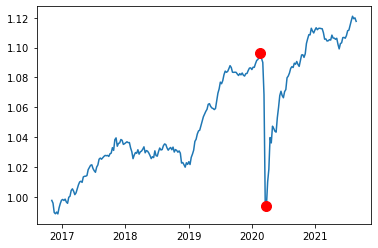

In [36]:
print("Strategy 1")

xs = daily_cum_ret['portfolio']
i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
j = np.argmax(xs[:i]) # start of period

plt.plot(xs)
plt.plot([daily_cum_ret.index[i], daily_cum_ret.index[j]], [xs.iloc[i], xs.iloc[j]], 'o', color='Red', markersize=10)

print("maximum drawdown: ", daily_cum_ret['portfolio'][i] - daily_cum_ret['portfolio'][j])

Strategy 2
maximum drawdown:  -0.20316220218521286


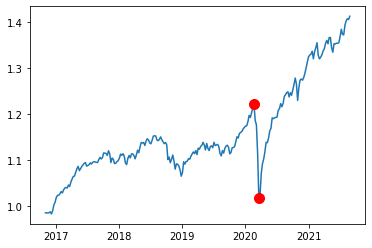

In [37]:
print("Strategy 2")

xs = daily_cum_ret_2['portfolio']
i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
j = np.argmax(xs[:i]) # start of period

plt.plot(xs)
plt.plot([daily_cum_ret_2.index[i], daily_cum_ret_2.index[j]], [xs.iloc[i], xs.iloc[j]], 'o', color='Red', markersize=10)

print("maximum drawdown: ", daily_cum_ret_2['portfolio'][i] - daily_cum_ret_2['portfolio'][j])

# Strategy 3: 

***Strategy 3:***
    
Continue now with the top 200 assets with the highest Sharpe Ratios for the training set.

- Q12: Run the Hierarchical Clustering method on this set to make three clusters.
- Q13: Pick the asset with the highest Sharpe ratio from the two smaller clusters.
- Q14: Run the Minimum Spanning Three method on the biggest cluster a number of timesuntil you are left with 3-4 assets only.
- Q15: Calculate the covariance matrix for these assets now and compare with the covariancematrix from strategy 1 and 2.
- Q16: Make an equal weight portfolio of these assets and test their performance on yourtesting data now.Compare the performance of the two strategies:
- Q17: Calculate average return, std for the two strategies and compare.
- Q18: Calculate and compare the Sharpe ratio for the two strategies.
- Q19: Calculate and compare maximum drawdown for the two strategies.

In [38]:
#subset, subset_df, corr_avg, PDI = MST.MinimumSpanningTree(best_200)
cluster_df = Clustering.Cluster(best_200, 3, False)

cluster_df

Complete_Corr    Cluster
DK0016306798              1  Cluster 1
DK0060005098              2  Cluster 2
DK0016044654              2  Cluster 2
DK0060356392              2  Cluster 2
DK0016202740              2  Cluster 2
...                     ...        ...
DK0060788420              1  Cluster 1
DK0010298272              1  Cluster 1
DK0060039824              1  Cluster 1
DK0060788503              1  Cluster 1
DK0060448918              1  Cluster 1

[200 rows x 2 columns]

In [39]:
cluster_1 = cluster_df[(cluster_df["Cluster"] == "Cluster 1")]
cluster_1_T = cluster_1.T
cluster_1 = train_data[cluster_1_T.columns]
len(cluster_1_T.columns)

106

In [40]:
cluster_2 = cluster_df[(cluster_df["Cluster"] == "Cluster 2")]
cluster_2_T = cluster_2.T
cluster_2 = train_data[cluster_2_T.columns]
len(cluster_2_T.columns)

93

In [41]:
cluster_3 = cluster_df[(cluster_df["Cluster"] == "Cluster 3")]
cluster_3_T = cluster_3.T
cluster_3 = train_data[cluster_3_T.columns]
cluster_3

DK0060158590
2012-01-11 00:00:00+00:00      0.000000
2012-01-18 00:00:00+00:00      0.000000
2012-01-25 00:00:00+00:00      0.000000
2012-02-01 00:00:00+00:00      0.001872
2012-02-08 00:00:00+00:00      0.000000
...                                 ...
2016-09-28 00:00:00+00:00      0.000000
2016-10-05 00:00:00+00:00      0.000298
2016-10-12 00:00:00+00:00      0.000000
2016-10-19 00:00:00+00:00      0.000000
2016-10-26 00:00:00+00:00      0.000000

[251 rows x 1 columns]

In [42]:
weeklymean_cluster_2 = calc_mean(cluster_2)
weeklycov_cluster_2 = cluster_2.cov()

annual_mean_cluster_2 = (1+weeklymean_cluster_2)**52-1
annual_cov_cluster_2 = weeklycov_cluster_2*52

stats_cluster_2 = pd.DataFrame(index = cluster_2.columns, columns  =["Ave Hist Returns (Ann)", "Stdev (Ann)", "Sharpe"])


stats_cluster_2["Ave Hist Returns (Ann)"] = annual_mean_cluster_2
stats_cluster_2["Stdev (Ann)"] = np.sqrt(np.diag(annual_cov_cluster_2))
stats_cluster_2["Sharpe"] = stats_cluster_2["Ave Hist Returns (Ann)"]/stats_cluster_2["Stdev (Ann)"]

cluster_2_best = stats_cluster_2.nlargest(1, 'Sharpe')
cluster_2_best

Ave Hist Returns (Ann)  Stdev (Ann)    Sharpe
DK0060005098                0.038332     0.014187  2.701868

In [43]:
subset, subset_df, corr_avg, PDI = MST.MinimumSpanningTree(cluster_1)
print("Average correlation of assets after",1,"iterations:",corr_avg)
print("Number of assets after",1,"iterations:",len(subset))

# 6 iterations of MST
for i in range (1,6):
    subset, subset_df, corr_avg, PDI = MST.MinimumSpanningTree(subset_df)
    print("\nAverage correlation of assets after",i+1,"iterations:",corr_avg)
    print("Number of assets after",i+1,"iterations:",len(subset))
print("\nMST subset of assets: \n")
subset

Average correlation of assets after 1 iterations: 0.5906429859319996
Number of assets after 1 iterations: 54

Average correlation of assets after 2 iterations: 0.5613821085970041
Number of assets after 2 iterations: 29

Average correlation of assets after 3 iterations: 0.5201944745961402
Number of assets after 3 iterations: 14

Average correlation of assets after 4 iterations: 0.4986026520512882
Number of assets after 4 iterations: 8

Average correlation of assets after 5 iterations: 0.5616049174729654
Number of assets after 5 iterations: 5

Average correlation of assets after 6 iterations: 0.5741588144775396
Number of assets after 6 iterations: 3

MST subset of assets: 



['DK0016272602', 'DK0060259356', 'LU1001671582']

In [44]:
train_cluster = train_data[['DK0016272602', 'DK0060259356', 'LU1001671582','DK0060005098','DK0060158590']]
test_cluster = test_data[['DK0016272602', 'DK0060259356', 'LU1001671582','DK0060005098','DK0060158590']]


In [45]:
# Training
weeklymean_train_cluster = calc_mean(train_cluster)
weeklycov_train_cluster  = train_cluster.cov()
annual_mean_train_cluster = (1+weeklymean_train_cluster)**52-1
annual_cov_train_cluster  = weeklycov_train_cluster*52

#Testing
weeklymean_test_cluster = calc_mean(test_cluster)
weeklycov_test_cluster = test_cluster.cov()
annual_mean_test_cluster = (1+weeklymean_test_cluster)**52-1
annual_cov_test_cluster = weeklycov_test_cluster*52

#print("The annual best train_cluster mean is:\n", annual_mean_train_cluster)
#print("\nThe annual best train_cluster cov matrix:\n", annual_cov_train_cluster)
#print('--------------------------------------------')
#print("The annual best test_cluster mean is:\n", annual_mean_test_cluster)
#print("\nThe annual best test_cluster cov matrix:\n", annual_cov_test_cluster)

In [46]:
w_eq = np.empty(5)
for i in range(5):
    w_eq[i] = 1/5
    
eqwp_return_train_cluster = np.sum(np.transpose(w_eq)*np.array(annual_mean_train_cluster))
eqwp_risk_train_cluster = np.sqrt(np.dot(np.transpose(w_eq), np.dot(annual_cov_train_cluster, w_eq)))

eqwp_return_test_cluster = np.sum(np.transpose(w_eq)*np.array(annual_mean_test_cluster))
eqwp_risk_test_cluster = np.sqrt(np.dot(np.transpose(w_eq), np.dot(annual_cov_test_cluster, w_eq)))


print("------Train------")
print("Return: ", eqwp_return_train_cluster)
print("Risk: ", eqwp_risk_train_cluster)
print("Sharp ratio: ",eqwp_return_train_cluster/eqwp_risk_train_cluster )
print("------Test------")
print("Return: ", eqwp_return_test_cluster)
print("Risk: ", eqwp_risk_test_cluster)
print("Sharp ratio: ",eqwp_return_test_cluster/eqwp_risk_test_cluster )

------Train------
Return:  0.12316758628583604
Risk:  0.05798498194264794
Sharp ratio:  2.124129078933908
------Test------
Return:  0.061818480213651085
Risk:  0.07747936132537456
Sharp ratio:  0.7978702864372409


------------------------------ Comparison of Covariance Matrices of Strategy 1, 2 and 3 ------------------------------ 



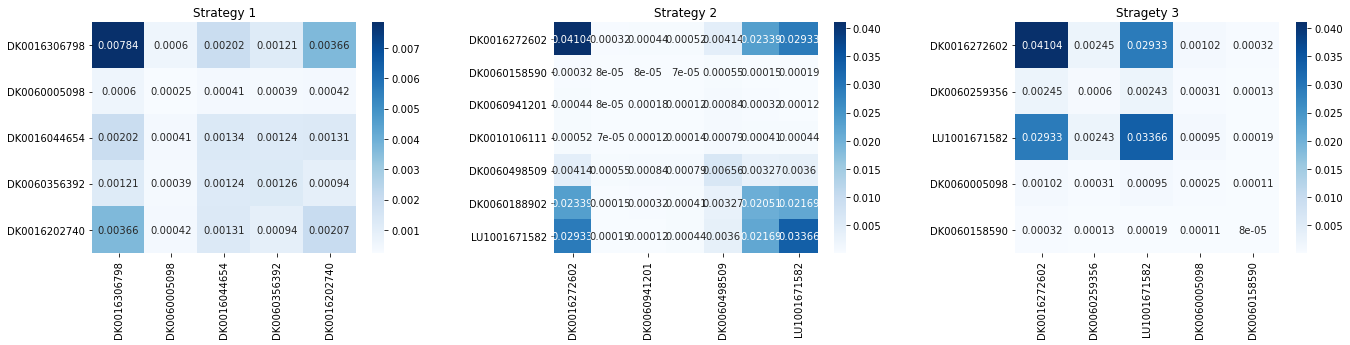

In [86]:
### Comparing the Covariance Matrix from Strategy 1 with the one from Strategy 2


fig, ax = plt.subplots(1,3)
#fig.suptitle('Covariance Matrices of Strategy 1 and Strategy 2\n')

print("-"*30,"Comparison of Covariance Matrices of Strategy 1, 2 and 3","-"*30,"\n")
### Heatmap of the Covariance Matrix from Strategy 1
sns.heatmap(round(annual_cov_best_test,5), 
            annot=True, fmt='g',cmap="Blues", ax=ax[0]).set(title="Strategy 1")

### Heatmap of the Covariance Matrix from Strategy 2
sns.heatmap(round(annual_cov_test_span,5), 
            annot=True, fmt='g',cmap="Blues", ax=ax[1]).set(title='Strategy 2')

### Heatmap of the Covariance Matrix from Strategy 3

sns.heatmap(round(annual_cov_test_cluster,5), 
            annot=True, fmt='g',cmap="Blues", ax=ax[2]).set(title="Stragety 3")


### Adjusting the plots to fit better
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=3.0, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

### Tool to see the format of the plot fit adjustment
#plt.subplot_tool() 

plt.show()

## Q16: Make an equal weight portfolio of these assets and test their performance on yourtesting data now.Compare the performance of the two strategies:

<function matplotlib.pyplot.show(close=None, block=None)>

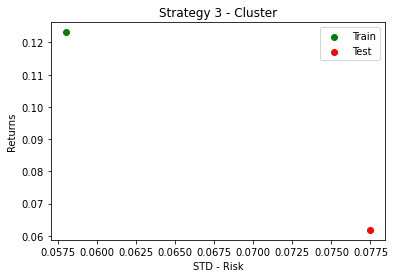

In [47]:
plt.scatter(eqwp_risk_train_cluster, eqwp_return_train_cluster, color = 'green', label = "Train")
plt.scatter(eqwp_risk_test_cluster, eqwp_return_test_cluster, color= 'red', label = "Test")
plt.legend()
plt.title("Strategy 3 - Cluster")
#plt.xlim(0, 0.1)
#plt.ylim(0, 0.1)
plt.xlabel('STD - Risk')
plt.ylabel('Returns')

plt.show

**Comparision - Testing**

<function matplotlib.pyplot.show(close=None, block=None)>

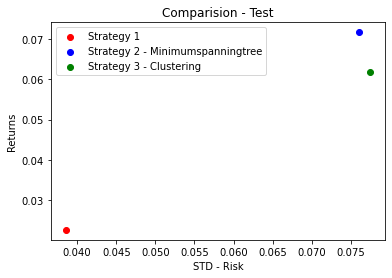

In [48]:
plt.scatter(eqwp_risk_test, eqwp_return_test, color= 'red', label = "Strategy 1")
plt.scatter(eqwp_risk_test_span, eqwp_return_test_span, color= 'blue', label = "Strategy 2 - Minimumspanningtree")
plt.scatter(eqwp_risk_test_cluster, eqwp_return_test_cluster, color= 'green', label = "Strategy 3 - Clustering")
plt.legend()
plt.title("Comparision - Test")
#plt.xlim(0, 0.1)
#plt.ylim(0, 0.1)
plt.xlabel('STD - Risk')
plt.ylabel('Returns')
plt.show

**Comparision - Training**

<function matplotlib.pyplot.show(close=None, block=None)>

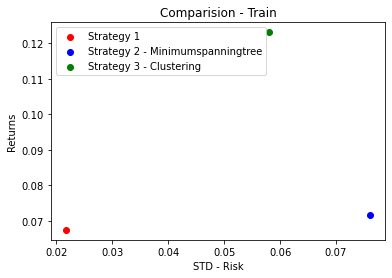

In [49]:
plt.scatter(eqwp_risk_train, eqwp_return_train, color= 'red', label = "Strategy 1")
plt.scatter(eqwp_risk_train_span, eqwp_return_train_span, color= 'blue', label = "Strategy 2 - Minimumspanningtree")
plt.scatter(eqwp_risk_train_cluster, eqwp_return_train_cluster, color= 'green', label = "Strategy 3 - Clustering")
plt.legend()
plt.title("Comparision - Train")
#plt.xlim(0, 0.1)
#plt.ylim(0, 0.1)
plt.xlabel('STD - Risk')
plt.ylabel('Returns')
plt.show

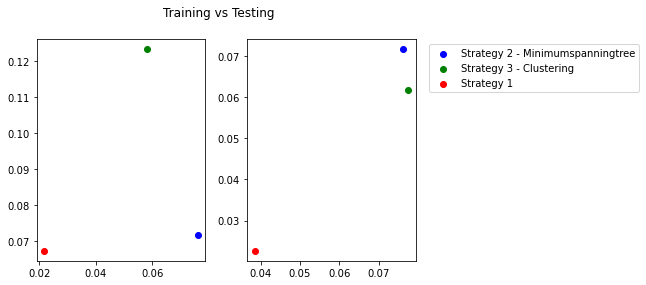

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training vs Testing')
fig.tight_layout()
ax1.scatter(eqwp_risk_train, eqwp_return_train, color= 'red', label = "Strategy 1")
ax1.scatter(eqwp_risk_train_span, eqwp_return_train_span, color= 'blue', label = "Strategy 2 - Minimumspanningtree")
ax1.scatter(eqwp_risk_train_cluster, eqwp_return_train_cluster, color= 'green', label = "Strategy 3 - Clustering")
ax2.scatter(eqwp_risk_test_span, eqwp_return_test_span, color= 'blue', label = "Strategy 2 - Minimumspanningtree")
ax2.scatter(eqwp_risk_test_cluster, eqwp_return_test_cluster, color= 'green', label = "Strategy 3 - Clustering")
ax2.scatter(eqwp_risk_test, eqwp_return_test, color= 'red', label = "Strategy 1")
plt.legend(loc="upper center", bbox_to_anchor=(1.7, 1), ncol=1)
plt.show()



In [51]:
print("-----------Testing-----------")
print("Sharp ratio - strategy 1 : ",eqwp_return_test/eqwp_risk_test)
print("Sharp ratio - strategy 2 : ",eqwp_return_test_span/eqwp_risk_test_span )
print("Sharp ratio - strategy 3 : ",eqwp_return_test_cluster/eqwp_risk_test_cluster )
print("-----------Training-----------")
print("Sharp ratio - strategy 1 : ",eqwp_return_train/eqwp_risk_train)
print("Sharp ratio - strategy 2 : ",eqwp_return_train_span/eqwp_risk_train_span )
print("Sharp ratio - strategy 3 : ",eqwp_return_train_cluster/eqwp_risk_train_cluster )

-----------Testing-----------
Sharp ratio - strategy 1 :  0.5876611334341308
Sharp ratio - strategy 2 :  0.9419233349533449
Sharp ratio - strategy 3 :  0.7978702864372409
-----------Training-----------
Sharp ratio - strategy 1 :  3.101344299094181
Sharp ratio - strategy 2 :  0.9419233349533449
Sharp ratio - strategy 3 :  2.124129078933908


In [52]:
weights = [1/5,1/5,1/5,1/5,1/5] 

In [53]:
test_cluster["portfolio"] = test_cluster.dot(weights)

C:\Users\bjark\Anaconda3\envs\BjarkiLord\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
daily_cum_ret_3 = (1 + test_cluster).cumprod()

## Q19: Calculate and compare maximum drawdown for the two strategies.

Strategy 3
maximum drawdown:  -0.19866960840061598


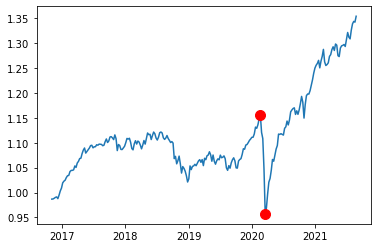

In [55]:
print("Strategy 3")

xs = daily_cum_ret_3['portfolio']
i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
j = np.argmax(xs[:i]) # start of period

plt.plot(xs)
plt.plot([daily_cum_ret_3.index[i], daily_cum_ret_3.index[j]], [xs.iloc[i], xs.iloc[j]], 'o', color='Red', markersize=10)

print("maximum drawdown: ", daily_cum_ret_3['portfolio'][i] - daily_cum_ret_3['portfolio'][j])

In [56]:
print("---Maximum drawdown---")
print("Strategy 1: ", daily_cum_ret['portfolio'][i] - daily_cum_ret['portfolio'][j])
print("Strategy 2: ", daily_cum_ret_2['portfolio'][i] - daily_cum_ret_2['portfolio'][j])
print("Strategy 3: ", daily_cum_ret_3['portfolio'][i] - daily_cum_ret_3['portfolio'][j])

---Maximum drawdown---
Strategy 1:  -0.09952721422656219
Strategy 2:  -0.20316220218521286
Strategy 3:  -0.19866960840061598


# Extra question

**EXTRA QUESTIONS:**

The starting point for these questions are the 4-5 assets that you have picked for yourportfolios in strategy 2 and 3. So in total you should perform the following statistical analysisfor each of these 8-10 assets.

- Q20: Draw histograms of returns for each of the assets.
- Q21: Draw density function of returns for each of the assets.
- Q22: Draw QQ-Plots of returns for each of the assets.
- Q23: Perform a Jarque-Bera test for normality of return distributions for each of the assets.
- Q24: Measure and report skewness of returns for each of the assets.
- Q25: Measure and report kurtosis of returns for each of the assets.
- Q26: For each of the assets, decide and report whether you can accept the return as beingnormally distributed

**Histogram Strategy 3**

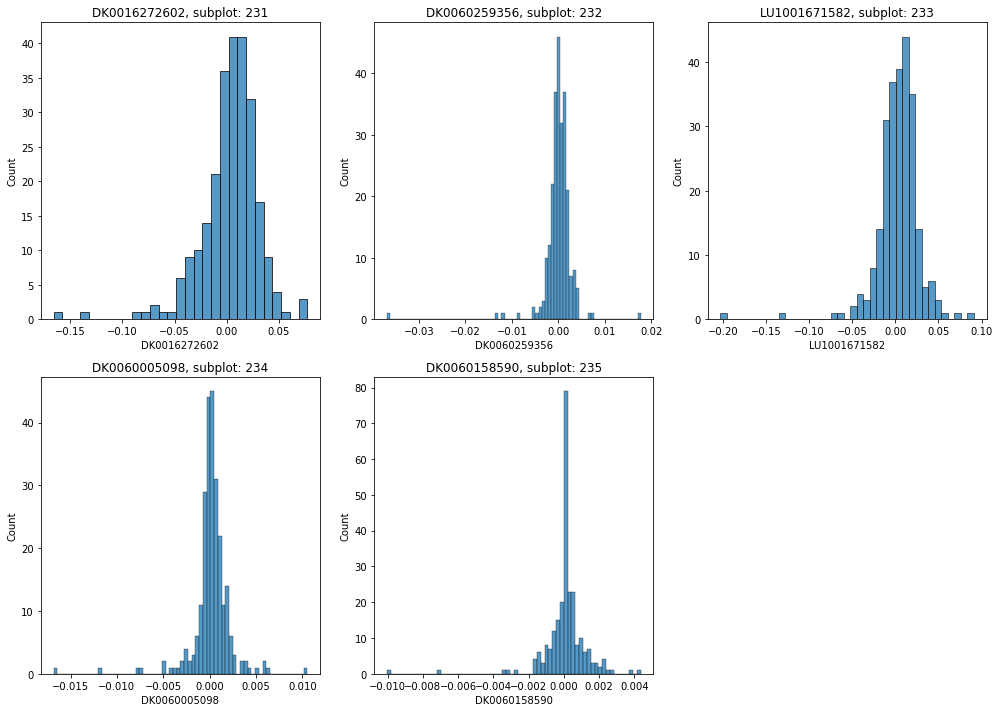

In [88]:
# Strategy 3

warnings.filterwarnings('ignore')

#  Categorical Data
heart_CAT = ['DK0016272602', 'DK0060259356', 'LU1001671582','DK0060005098','DK0060158590']

#  Categorical Data
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,10))

for i in heart_CAT:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.histplot(data=test_data, x=test_data[i])
    c = c + 1
    
fig.tight_layout()
plt.show()

**Histogram Strategy 2**

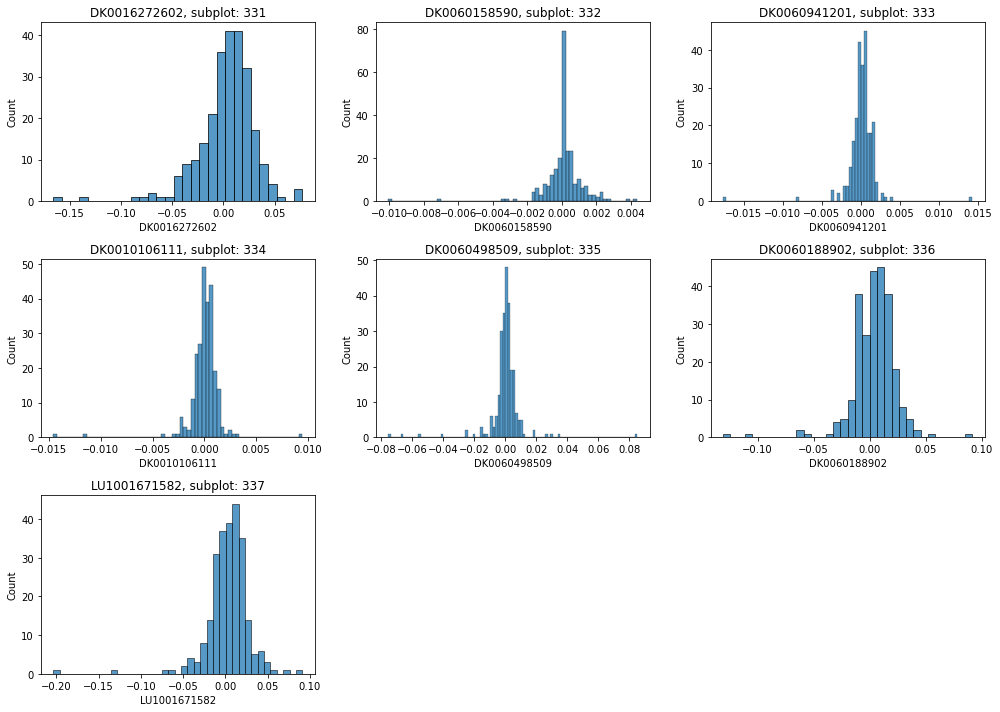

In [90]:
# Strategy 2

warnings.filterwarnings('ignore')

#  Categorical Data
heart_CAT = ['DK0016272602','DK0060158590','DK0060941201','DK0010106111','DK0060498509','DK0060188902','LU1001671582']

#  Categorical Data
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,10))

for i in heart_CAT:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.histplot(data=test_data, x=test_data[i])
    c = c + 1
    
fig.tight_layout()
plt.show()



**Density function Strategy 3**

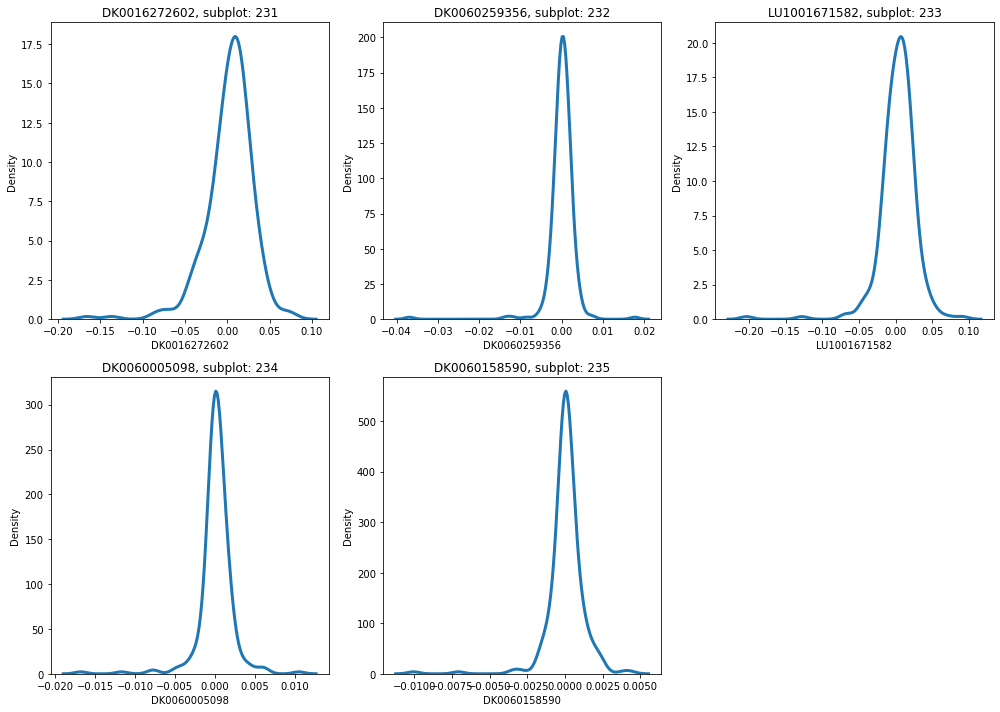

In [60]:
# Strategy 3

strategy_3 = ['DK0016272602', 'DK0060259356', 'LU1001671582','DK0060005098','DK0060158590']

warnings.filterwarnings('ignore')

#  Categorical Data
heart_CAT = ['DK0016272602', 'DK0060259356', 'LU1001671582','DK0060005098','DK0060158590']

#  Categorical Data
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,10))

for i in heart_CAT:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.distplot(test_data[i], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = test_data[i])
    c = c + 1
    
fig.tight_layout()
plt.show()

**Density function Strategy 2**

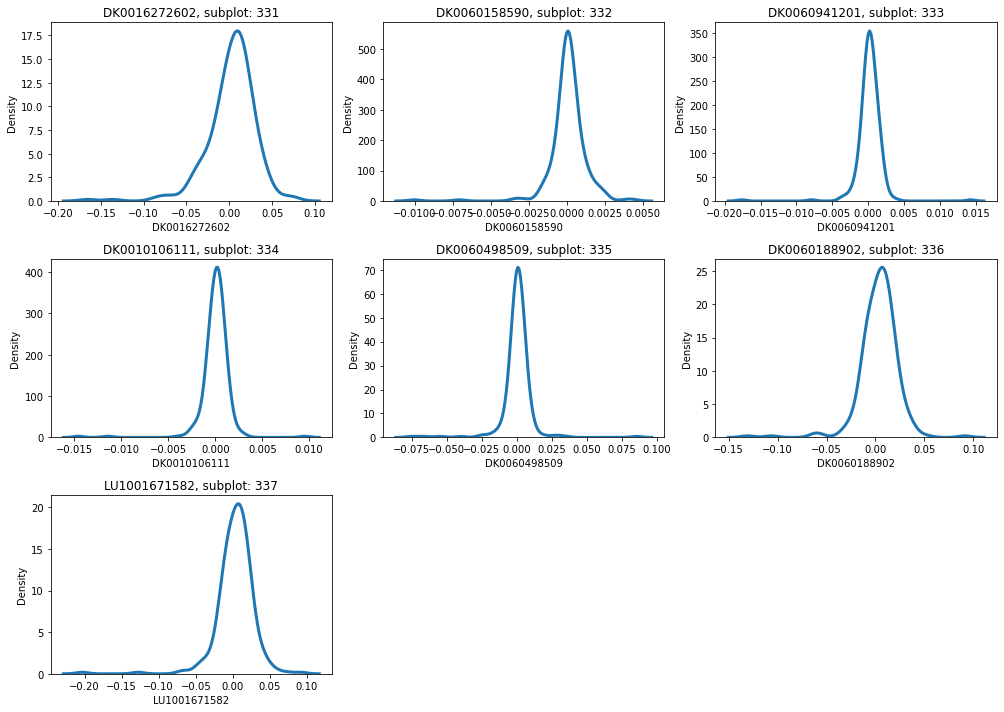

In [61]:
# Strategy 2

warnings.filterwarnings('ignore')

#  Categorical Data
heart_CAT = ['DK0016272602','DK0060158590','DK0060941201','DK0010106111','DK0060498509','DK0060188902','LU1001671582']

#  Categorical Data
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,10))

for i in heart_CAT:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.distplot(test_data[i], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = test_data[i])
    c = c + 1
    
fig.tight_layout()
plt.show()

**QQ-plot strategy 3**

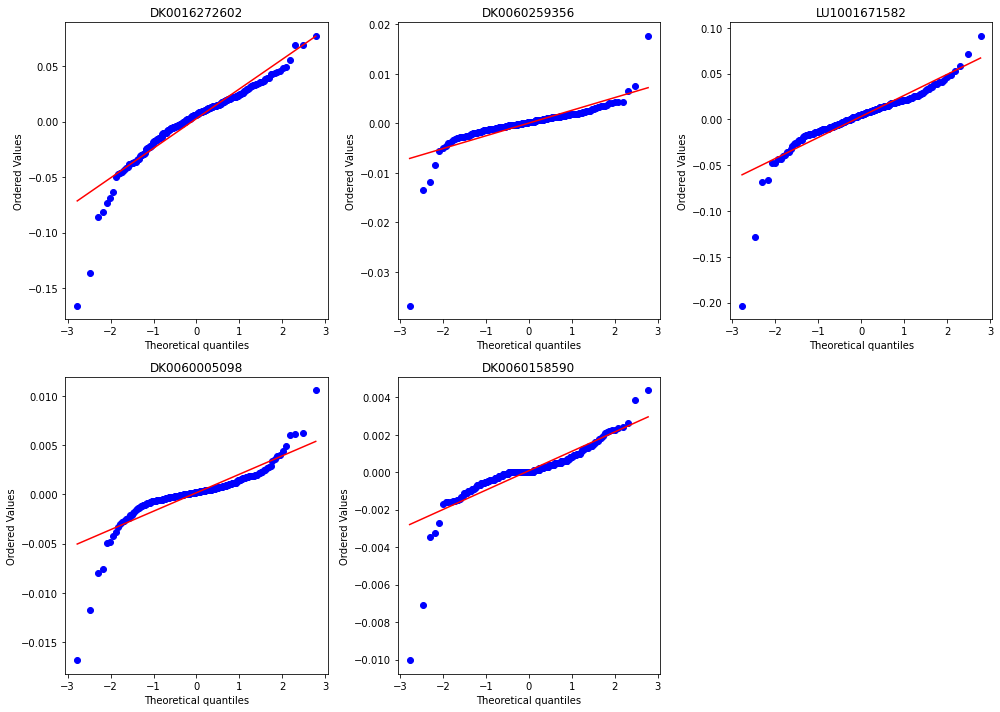

In [84]:
import numpy as np 
import pylab 
import scipy.stats as stats

warnings.filterwarnings('ignore')

#  Categorical Data
heart_CAT = ['DK0016272602', 'DK0060259356', 'LU1001671582','DK0060005098','DK0060158590']

#  Categorical Data
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,10))

for i in heart_CAT:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    stats.probplot(test_data[i], dist="norm", plot=pylab)
    plt.title(i)
    c = c + 1
    
fig.tight_layout()
pylab.show()



**QQ-plot strategy 2**

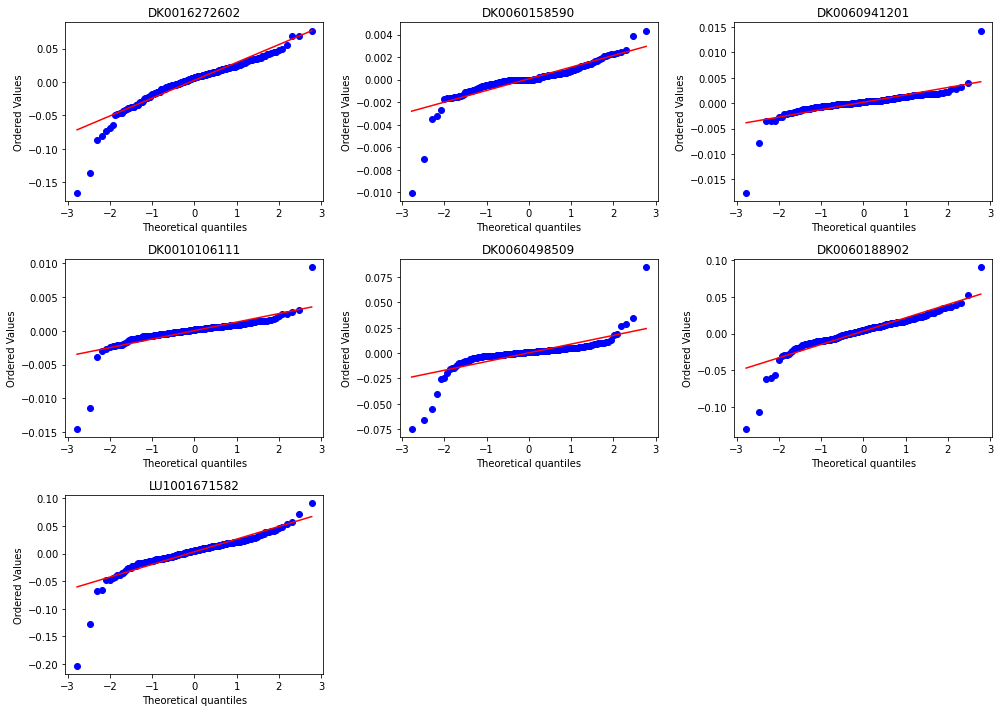

In [83]:
import numpy as np 
import pylab 
import scipy.stats as stats

warnings.filterwarnings('ignore')

#  Categorical Data
heart_CAT = ['DK0016272602','DK0060158590','DK0060941201','DK0010106111','DK0060498509','DK0060188902','LU1001671582']

#  Categorical Data
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,10))

for i in heart_CAT:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    stats.probplot(test_data[i], dist="norm", plot=pylab)
    c = c + 1
    plt.title(i)
    
fig.tight_layout()
pylab.show()


**Jarque-Bera test for normality**

The Jarque-Bera Test is typically used for large datasets (n > 2000) in which other normality tests (like the Shapiro-Wilk test) are unreliable.

In [117]:
import numpy as np
import scipy.stats as stats

strategy_3 = ['DK0016272602', 'DK0060259356', 'LU1001671582','DK0060005098','DK0060158590']

print("---------------Strategy 3---------------")

for i in strategy_3:
    #perform Jarque-Bera test
    print(i, stats.jarque_bera(test_data[i]))
    
strategy_2 = ['DK0016272602','DK0060158590','DK0060941201','DK0010106111','DK0060498509','DK0060188902','LU1001671582']

print("---------------Strategy 2---------------")

for i in strategy_2:
    #perform Jarque-Bera test
    print(i, stats.jarque_bera(test_data[i]))


---------------Strategy 3---------------
DK0016272602 Jarque_beraResult(statistic=638.6707330243731, pvalue=0.0)
DK0060259356 Jarque_beraResult(statistic=37460.880267588356, pvalue=0.0)
LU1001671582 Jarque_beraResult(statistic=4228.304117321769, pvalue=0.0)
DK0060005098 Jarque_beraResult(statistic=4286.359309243013, pvalue=0.0)
DK0060158590 Jarque_beraResult(statistic=6570.586266513171, pvalue=0.0)
---------------Strategy 2---------------
DK0016272602 Jarque_beraResult(statistic=638.6707330243731, pvalue=0.0)
DK0060158590 Jarque_beraResult(statistic=6570.586266513171, pvalue=0.0)
DK0060941201 Jarque_beraResult(statistic=21898.551986221108, pvalue=0.0)
DK0010106111 Jarque_beraResult(statistic=16936.51609852191, pvalue=0.0)
DK0060498509 Jarque_beraResult(statistic=7737.49608051089, pvalue=0.0)
DK0060188902 Jarque_beraResult(statistic=1830.9493229799832, pvalue=0.0)
LU1001671582 Jarque_beraResult(statistic=4228.304117321769, pvalue=0.0)


The test statistic is often very high and the corresponding p-value is 0.0. Since this p-value is less than 0.05, we reject the null hypothesis.

**Test skewness and kurtosis**

In [132]:
for i in strategy_3:
    print("--------", i ,"--------" )
    print("Kurtosis: ", test_data[i].kurtosis())
    print("Skewness: ",test_data[i].skew())
    


-------- DK0016272602 --------
Kurtosis:  7.2542317079493515
Skewness:  -1.6372460610130273
-------- DK0060259356 --------
Kurtosis:  60.07880010680051
Skewness:  -5.081717450839644
-------- LU1001671582 --------
Kurtosis:  19.799529127877634
Skewness:  -2.609391408324225
-------- DK0060005098 --------
Kurtosis:  20.12300090663478
Skewness:  -2.2521086282614498
-------- DK0060158590 --------
Kurtosis:  24.82777637931736
Skewness:  -2.9583439084917065


In [133]:
for i in strategy_2:
    print("--------", i ,"--------" )
    print("Kurtosis: ", test_data[i].kurtosis())
    print("Skewness: ",test_data[i].skew())
    

-------- DK0016272602 --------
Kurtosis:  7.2542317079493515
Skewness:  -1.6372460610130273
-------- DK0060158590 --------
Kurtosis:  24.82777637931736
Skewness:  -2.9583439084917065
-------- DK0060941201 --------
Kurtosis:  46.40927763111375
Skewness:  -2.138167348684649
-------- DK0010106111 --------
Kurtosis:  40.302423117990735
Skewness:  -3.698183063526234
-------- DK0060498509 --------
Kurtosis:  27.661223015504984
Skewness:  -0.862962972498725
-------- DK0060188902 --------
Kurtosis:  12.972218398040301
Skewness:  -1.8327024933133043
-------- LU1001671582 --------
Kurtosis:  19.799529127877634
Skewness:  -2.609391408324225
